In this notebook I will follow the [lectures](https://indico.cern.ch/event/688110/contributions/2834476/attachments/1638836/2627592/9_montepython_final.mp4) held at Cosmo Tools Schools ([here](https://lesgourg.github.io/class-tour/Cambridge/180912_MontePython_Cambridge.pdf) you can find the related slides) to solve a few selected exercises: the objective is to reach a good comprehension about some advanced features of the python's inference package __MontePython__ in order to use it in the next notebook, where I will analyze the latest BOSS measurements in the context of the EFT cosmological model.

In [52]:
import os, sys
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import matplotlib.pyplot as plt
import yaml

In [53]:
# Define chain folder
chain_dir = os.path.join(os.getcwd(), 'chains')
chain_dir

'/home/errez/code/montepython_tutorial/chains'

### Exercise 1: the $\Omega_m-\Omega_\Lambda$ plane
This exercise relies on constraints from the cosmic expansion: is fast enough to be done on a laptop. You can let it run during the coffee break and make some cool plots when you come back!
We will obtain Baryon Acoustic Oscillation (BAO) constraints on the $Ω_m − Ω_Λ$ plane for a two parameter model. __We will vary $Ω_{cdm}$ and $Ω_k$, keeping $Ω_b$ and $H_0$ fixed by setting the $1σ$ values to zero__ (recall $Ω_Λ$ is a derived parameter). Use the following example:

    data.experiments=['bao_boss_dr12','bao_smallz_2014']
    data.parameters['Omega_cdm'] = [0.3, 0, None, 0.05, 1, 'cosmo']
    data.parameters['Omega_k'] = [0.0, -0.5,0.5, 0.05, 1, 'cosmo']
    data.parameters['Omega_b'] = [0.045, 0, None, 0.0, 1, 'cosmo']
    data.parameters['h'] = [0.68, 0, None, 0, 1, 'cosmo']
    data.parameters['Omega_Lambda'] = [1,None,None,0, 1, 'derived']
    data.cosmo_arguments['YHe'] = 0.24
    data.N=10
    data.write_step=5

This input file is then saved as `lc_bao.param`.

*Note*: the limits on $Ω_k$ are such that CLASS does not complain. Fixing the Helium fraction $Y_{He}$ is good to run other cases, like SNe constraints varying $Ω_b$ as well.

__a)__ Write the above into a `.param` file and do a short Monte Python run:
<center>

    $ time python montepython/MontePython.py -p input/lc_bao.param -o chains/lc_bao -N 10
</center>

The `time` prefix is just to know how long it will take (you can use that information to adjust the parameters to how much time you have).

__b)__ Now you can do the serious run:
<center>

    $ mpirun -np 4 python montepython/MontePython.py -o chains/lc_bao -N 10000
</center>

where you can adjust N to a larger number (`-N 10000` should be feasible, if you take a longer break
you can increase accordingly). Because you are running from a folder with a `log.param` you do
not need to provide the `.param` file again.\
In order to speed up convergence `--update 50` (default value, to improve the covariance matrix on the fly) and/or provide a covariance matrix with `-c name.covmat` (MP will interpret the
parameters for you). You can also benefit from setting `--superupdate 20` (adapt jumping factor
to optimize acceptance rate).\
The call `mpirun -np 4` at the begining of the command runs 4 chains in the same console (adjust
`-np` to your number of cores). If you don't have *openmpi* you can remove `mpirun` and just run on
`-np` different consoles.

*Tip*: you can go to the output directory and type `wc -l *.txt` to count how many points there are in the `.txt` files.

__c)__ Analyze the chains. You can use MP in info mode:
<center>

    $ python montepython/MontePython.py info chains/lc_bao
</center>

plus the optional options. Take a look at the nice plots in `chains/lc_bao/plots` and all the other files
generated in the analysis. We are going to use GetDist as well to reproduce the plots here.

In [54]:
# Load the samples using GetDist: attention to the complete name of the chain!
from getdist import loadMCSamples, plots, mcsamples, MCSamples
samples = loadMCSamples(file_root=chain_dir+'/lc_bao/2023-10-09_10000_', settings={'ignore_rows':0});
samples.name_tag = 'LC BAO'

In [55]:
# GetDist does not recognise derived parameters as such
print('Running parameters: ', np.transpose(samples.getParamNames().getRunningNames()))
print('Derived parameters: ', np.transpose(samples.getParamNames().getDerivedNames()))
par_names = samples.getParamNames().list()

Running parameters:  ['Omega_cdm' 'Omega_k' 'Omega_Lambda']
Derived parameters:  []


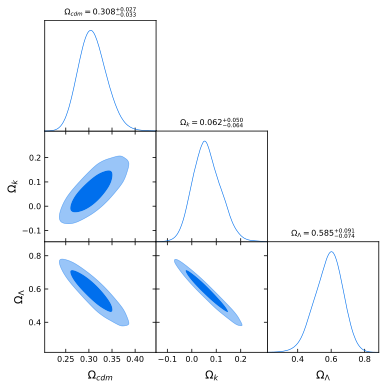

In [56]:
# Triangle plot
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples], filled=True, title_limit=1)

*Note*: the best-fit values displayed in the previous plot are not exactly the same as the ones in the MontePython plots. This is due to the fact that MP does not provide a `.minimum` file that contains the MAP for each parameter, therefore GetDist performs its own MAP on the available samples, resulting in slight differences on the final values. In particular, here we can notice deviations on the $1\sigma$ intervals.

In [57]:
# Here you can get the values obtained with the MAP on the samples: it is always better to use the mean values
samples.getLatex()

(['\\Omega{}_{cdm }', '\\Omega{}_{k }', '\\Omega{}_{\\Lambda }'],
 ['0.308^{+0.027}_{-0.033}',
  '0.062^{+0.050}_{-0.064}',
  '0.585^{+0.091}_{-0.074}'])

In [58]:
# Means and variances
params = samples.getParamNames().list()
for name, mean, var in zip(params, samples.getMeans(), samples.getVars()):
    for _ in range(12 - len(name)):
        print(' ', end='')
    print(f'{name}', end='')
    print(f' = {mean:0.3f} +- {np.sqrt(var):0.3f}')

   Omega_cdm = 0.308 +- 0.031
     Omega_k = 0.062 +- 0.057
Omega_Lambda = 0.585 +- 0.083


__d)__ You are encouraged to play with the different options: try to plot the marginalized contours using
$Ω_m = Ω_{cdm} + Ω_b$ instead of $Ω_{cdm}$.

Note that we do NOT have a chain for $\Omega_b$ (neither for $H_0$) since we did not vary it during sampling (see the beginning of the notebook). Thus, $\Omega_b$ is fixed to the given value of $\Omega_b = 0.045$.

In [59]:
p = samples.getParams()
samples.addDerived(p.Omega_cdm + 0.045, name='Omega_m', label='\Omega_m')

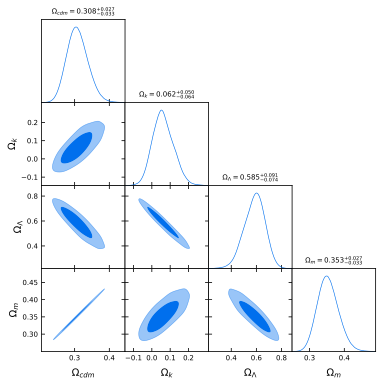

In [60]:
# Triangle plot: of course we expect 100% correlation between Omega_cdm and Omega_m
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples], filled=True, title_limit=1)

__e)__ Once you have several datasets (some ideas are suggested below) you can plot them together. Just
feed MP info mode with several folders. How do the different constraints compare?\
**Supernovae**: There are other background observations besides BAO, like type 1A Supernovae (SNe).
Run the same model with the Union SNe compilation with `data.experiments=['sn']`.

In [61]:
samples1 = loadMCSamples(file_root=chain_dir+'/lc_sn/2023-10-09_10000_', settings={'ignore_rows':0});
samples1.name_tag = 'LC SN'

p = samples1.getParams()
samples1.addDerived(p.Omega_cdm + 0.045, name='Omega_m', label='\Omega_m')

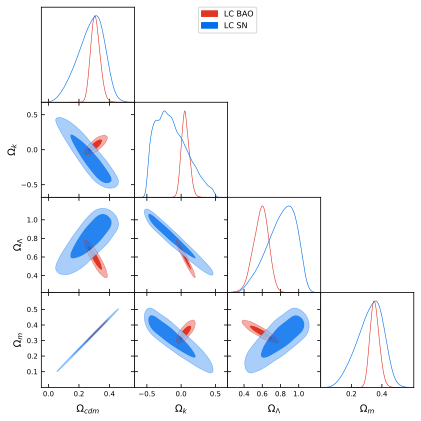

In [62]:
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples, samples1], filled=True)

As you can see the BAO measurements give a way better constraint on the parameter. The SN dataset even ends up with a negative value of $\Omega_k$. In the end, it seems that the SN dataset reaches a decent precision only on $\Omega_{cdm}$.

### Exercise 2: Realistic BAO (adding a new prior)
By not varying $Ω_b$, $H_0$ we are fixing the comoving BAO scale $r_s$ (i.e. the coordintate
size of the standard ruler). Although $r_s$ is well constrained by the CMB, there is some variability, which
you may take into account by letting $Ω_b$ vary within some range.
Do a run varying the baryon fraction. You can do this in two ways:
1) *More elegant*: add a gaussian prior on $ω_b ≡ Ω_bh^2$.
2) *Easier*: add a hard prior to allow for $2σ$ deviations (change `Omega_b -> omega_b` in the `.param` file,
as well as the central value and limits).

We want to add a gaussian prior on $\omega_b$ (*physical* baryon density fraction) using Planck results:

$$\omega_b \equiv \Omega_bh^2 = 0.02222 \pm 0.00023$$

In order to add this prior in MP just follow the instructions below:
1) Copy a simple likelihood folder from `montepython/likelihoods` (for instance `hst`) and rename it
as `cmb_baryon`. Change the name of the `.data` file to be `cmb_baryon.data`.
2) In `cmb_baryon.data` change `hst→cmb_baryon` and `h→omega_b`. Update the central value and
standard deviation according to the given value.
3) Update `__init__.py` by changing the name of the class, the data (as given `.data` file, it is read
as `self.xxx`) and the theoretical value (`cosmos.omega_b()` as given by classy).

To visualize this prior distribution (and get the MCMC sampling) we can launch a basic run such as:

    $ mpirun -np 4 python montepython/MontePython.py -p input/omega_b_prior.param -o chains/omega_b_prior -N 10000

where the `omega_b_prior.param` file just connects the parameter $\omega_b$ to the previous likelihood (prior) but with no data:

    data.experiments=['cmb_baryon']
    data.parameters['omega_b'] = [2, 0, None, 0.02, 1e-2, 'cosmo']
    data.N=10
    data.write_step=5

In [63]:
# New lc_bao chain with omega_b prior
samples2 = loadMCSamples(file_root=chain_dir+'/lc_bao_omega_b/2023-10-10_10000_', settings={'ignore_rows':0});
samples2.name_tag = 'LC BAO + $\omega_b$ Prior'

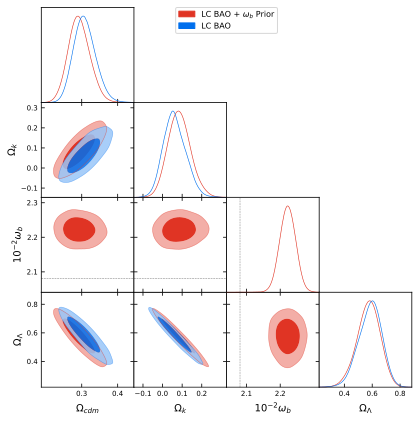

In [64]:
# The grey line corresponds to the fixed omega_b value used in the first run
fixed_value = (0.045 * 0.68 * 0.68)*100
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples2, samples], samples2.getParamNames().list(), filled=True,
                markers={'omega_b':fixed_value})

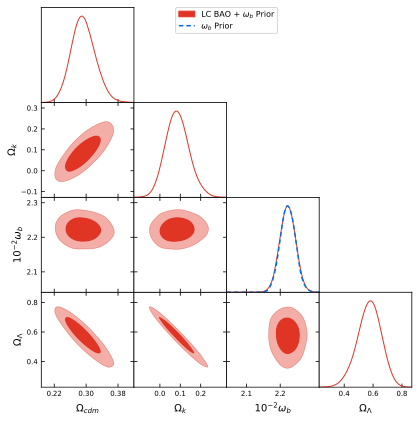

: 

In [65]:
omega_b_prior = loadMCSamples(file_root=chain_dir+'/omega_b_prior/2023-10-10_10000_', settings={'ignore_rows':0})
omega_b_prior.name_tag = '$\omega_b$ Prior'

# Plotting the posterior distribution with the omega_b prior
g.settings.line_styles = 'tab10'
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples2, omega_b_prior], samples2.getParamNames().list(), filled=True,
                contour_ls=['-', '--'],
                contour_lws=[1, 1.5])

In this way we are varying also $h$ and $\Omega_b$: to get their chains we simply use the `.addDerived()` method from GetDist, both for the posterior and prior chain.